In [2]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh_TGV1')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import Optics
from HHG import ActiveGrating
import Graph

Grating = Optics.Grating()

In [3]:
IR = Optics.Pulse(w0=80e-6, lam=800e-9, wt=50e-15)
IR2 = Optics.Pulse(w0=20e-6, lam=800e-9, wt=10e-15)

grid = IR.Grid(Lx=2e-3, Ly=250e-15, Nx=3001, Ny=5001)
STOV = 0.8*IR.LG_STOV(grid[0], 0, grid[1], l=1, p=0) # Axis0 = time, Axis1 = x

offset = 6*IR.w0
theta = 0.0
REF = IR2.LG_STOV((grid[0]-offset), 0, grid[1]-(grid[0]-offset)*np.sin(theta)/1e9, l=0, p=0) # Axis0 = time, Axis1 = x

DRIVER = STOV+REF

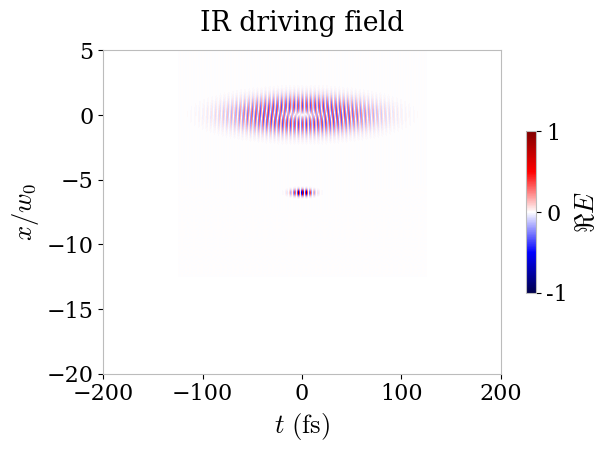

In [4]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, tight_layout=True)

x, t = grid[0][0], grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
t = t/1e-15
extent=[t[0], t[-1], x[0], x[-1]]

im = ax.imshow(np.real(DRIVER).T/np.max(np.real(DRIVER)), cmap='seismic', aspect='auto', extent=extent, vmin=-1, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar.ax.set_ylabel('$\Re E$')


ax.set_xlim(-200, 200)
ax.set_ylim(-20,5)

ax.set_xlabel('$t \ \mathrm{(fs)}$')
ax.set_ylabel('$x/w_0$')

#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax.set_title('IR driving field')

plt.show()

In [5]:
AG = ActiveGrating(qeff=3.5)
XUV_STOV = 0

for q in [7, 9, 11, 13, 15, 17, 19, 21]:
    XUV_STOV += AG.Hq_NearField(IRfield=DRIVER, q=q)

XUVspectrum, xw_grid = Grating.Disperse(field_0=XUV_STOV, grid_xt=grid)

In [14]:
%matplotlib qt
fig, ax = plt.subplots(1, 1, tight_layout=True)

x, t = grid[0][0], grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
t = t/1e-15
extent=[t[0], t[-1], x[0], x[-1]]

val=np.abs(XUV_STOV).T/np.max(np.abs(XUV_STOV))
im = ax.imshow(np.log(val), cmap='inferno', aspect='auto', extent=extent, vmin=-100)

cbar = plt.colorbar(im, orientation='vertical', shrink=0.5, aspect=15)
cbar.ax.set_ylabel('$|E|$')


ax.set_xlim(-200, 200)
ax.set_ylim(-20,5)

ax.set_xlabel('$t \ \mathrm{(fs)}$')
ax.set_ylabel('$x/w_0$')

#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax.set_title('Harmonic field')

plt.show()

C:\Users\tg263331\AppData\Local\Temp\ipykernel_13772\69558683.py:10: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(val), cmap='inferno', aspect='auto', extent=extent, vmin=-100)


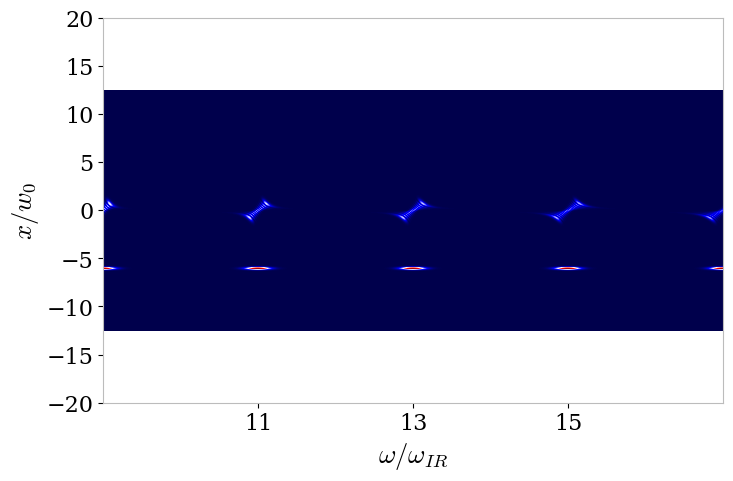

In [106]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,5))

x, w = xw_grid[0][0], xw_grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
w = w/IR.omega
extent=[w[0], w[-1], x[0], x[-1]]

ax.imshow(np.abs(XUVspectrum).T, cmap='seismic', aspect='auto', extent=extent)

ax.set_xlim(9, 17)
ax.set_ylim(-20, 20)

ax.set_xlabel(r'$\omega/\omega_{IR}$')
ax.set_ylabel(r'$x/w_0$')

ax.set_xticks([11, 13, 15], [11, 13, 15])

plt.show()

In [107]:
x, w = xw_grid[0][0], xw_grid[1].T[0] # retrieve axes from meshgrid
Lx, Lw = x[-1]-x[0], w[-1]-w[0]
Nx, Nw = len(x), len(w)

test = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(XUVspectrum, axes=1), axis=1), axes=1)
test = test * (Lx/(Nx-1))
d=1
xp = np.fft.fftshift(np.fft.fftfreq(Nx, Lx/(Nx-1)))*d
lam_axis = 2*np.pi*3e8/w

for i in range(len(test)):
    test[i] = np.interp(xp*lam_axis[0], xp*lam_axis[i], test[i]) / lam_axis[i] 

C:\Users\tg263331\AppData\Local\Temp\ipykernel_15216\1955932188.py:9: RuntimeWarning: divide by zero encountered in divide
  lam_axis = 2*np.pi*3e8/w
C:\Users\tg263331\AppData\Local\Temp\ipykernel_15216\1955932188.py:12: RuntimeWarning: invalid value encountered in multiply
  test[i] = np.interp(xp*lam_axis[0], xp*lam_axis[i], test[i]) / lam_axis[i]


In [108]:
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(6,3))

x, w = xp*lam_axis[0], xw_grid[1].T[0]
x = x*1e3
w = w/IR.omega
extent=[w[0], w[-1], x[0], x[-1]]


# im = Graph.Phase2D().colorize(test.T, mode='Amplitude')
# ins = Graph.Phase2D().key_inset(mode='Amplitude', ax=ax)

# ax.imshow(im, aspect='auto', extent=extent)

ax.imshow(np.abs(test.T)**2, aspect='auto', extent=extent, cmap='Blues_r')

ax.set_xlim(5, 25)
ax.set_ylim(-30, 30)

ax.set_xlabel(r'$\omega/\omega_{IR}$')
ax.set_ylabel(r'$\theta \ \mathrm{(mrad)}$')

ax.set_xticks([7, 9, 11, 13, 15, 17, 21, 23], [7, 9, 11, 13, 15, 17, 21, 23])
ax.set_yticks([-10, -5, 0, 5, 10], [-10, -5, 0, 5, 10])

ax.set_title('XUV spectrum')

plt.show()